In [1]:
from combine_fuction import combine_2d
import combine_fuction
from combine_fuction import same_dimension
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import aplpy
import matplotlib as mpl
%matplotlib inline

/Users/shjiao/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# 1 D example for a point source

In [4]:
from astropy.convolution import convolve, Gaussian1DKernel


#define 1d smooth function
def gauss_1d(
    data_1d,
    fwhm,
    pixel,
    ):
    """
        Purpose:
        smooth 1d data to a target resolution,
        and the output the smoothed 1d data
        
        Input:
        data_1d        [float array]: input 1d data
        fwhm           [float] : target angular resolution (FWHM)
        pixel          [float] : The pixel size       
        
        Output:  
        data_sm_1d        [float array]: smoothed 1d data
    """

    FWHM_TO_SIGMA = 1./np.sqrt(8*np.log(2))
    kernel_size=fwhm*FWHM_TO_SIGMA
    pixel_n = kernel_size/pixel
    gauss_1D_kernel =Gaussian1DKernel(pixel_n)
    smoothed_data_gauss = convolve(data_1d, gauss_1D_kernel,normalize_kernel=True)
    
    return smoothed_data_gauss

Simulate a 1D point source data and smooth it to high (grey line) and low resolution (red line). For high resolution data, I take out the large scale struction and then get the fake interferometer data (lime line).

(array([-0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 <a list of 10 Text yticklabel objects>)

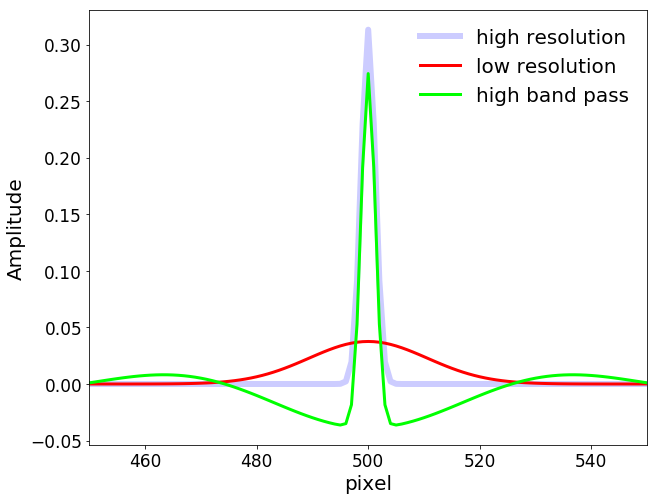

In [49]:
plt.figure(figsize=(10, 8))
x = np.linspace(0, 1000, 1001)
y = np.zeros(1001)
y[500] = 1.

# plot high resolution and low resolution data
data_high = gauss_1d(y,12,4.)
data_low = gauss_1d(y,100,4.)

plt.plot(x,data_high,color = (0, 0, 1.0, 0.2), linewidth = 6.,label='high resolution')
plt.plot(x,data_low,color = 'red',linewidth = 3.,label='low resolution')

# plot high resolution data without large scale struction
y = np.linspace(0, 1000, 1001)
rr = ((y-500)**2)**0.5
rr = rr.flatten()
step_th = (rr>=20) 
data_high_int = np.fft.ifft(np.fft.fft(data_high) * (np.fft.fftshift(step_th)))
plt.plot(x,data_high_int,color = 'lime',linewidth = 3.,label='high band pass')




plt.xlim(450,550)
legend = plt.legend(loc='upper right', shadow=True, fontsize=20.,frameon=False)
plt.xlabel('pixel',fontsize=20.)
plt.ylabel('Amplitude',fontsize=20.)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

What we want to do is to combine the low resolution (red line) and interferometer data (lime line) to get high resolution data (grey line). 
Here we test how would the results change with different input parameter (k_min, k_max, and n => step frequency).

The fake interferometer data lose the structures at lager scale (rr>20).
From this test, we know that, for a good combination, the used spatial frequncy threshold should be within the spatial scale, in which the high-resolution map can cover with accurate information.


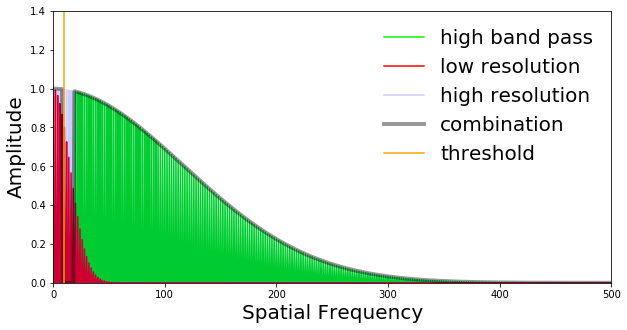

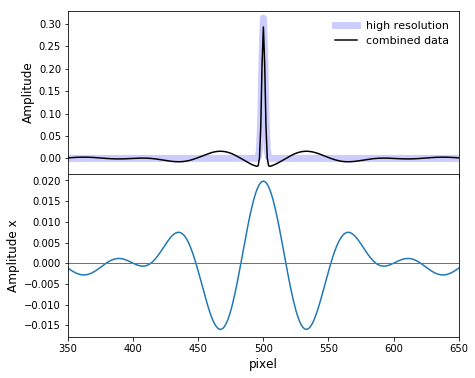

In [50]:
#J-comb, following Section 2.3

#for the fake interferometer data, step_th = (rr>=20)
step = (rr>=10) ######bad

w_low = (np.fft.fftshift(1-step)*np.fft.fft(data_high)/np.fft.fft(data_low))
fftsum = np.fft.fft(data_low) * w_low + np.fft.fft(data_high_int) * (np.fft.fftshift(step))


plt.figure(figsize=(10, 5))

plt.plot(x,np.fft.fft(data_high_int),color = 'lime',label='high band pass')
plt.plot(x,np.fft.fft(data_low),color = 'red',label='low resolution')
plt.plot(x,np.fft.fft(data_high),color = (0, 0, 1.0, 0.2),label='high resolution')


plt.plot(x,np.abs(fftsum.real),linewidth = 4.,label='combination',linestyle='-',color = 'black',alpha=0.4)

plt.axvline(x= 10, color ='orange',label='threshold') 

plt.xlim(0,500)
plt.ylim(0,1.4)
legend = plt.legend(loc='upper right', shadow=True, fontsize=20.,frameon=False)
plt.xlabel('Spatial Frequency',fontsize=20.)
plt.ylabel('Amplitude',fontsize=20.)




########to image domain#######
combine = np.fft.ifft(fftsum)


fig, axs = plt.subplots(2, 1, sharex=True,figsize=(7, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(x,data_high,color = (0, 0, 1.0, 0.2), linewidth = 7.,label='high resolution')
#axs[0].plot(x,data_low,color = 'red',linewidth = 3.,label='low resolution')
#axs[0].plot(x,data_high_int,color = 'lime',linewidth = 3.,label='high resolution (int)')
axs[0].plot(x, combine,color = 'black',label='combined data')
axs[0].set_xlim(350, 650)
legend = axs[0].legend(loc='upper right', shadow=True, fontsize=11,frameon=False)
sub = data_high - combine

#axs[1].plot(x, sub * 1e15)
axs[1].plot(x, sub)

axs[1].set_xlabel('pixel',fontsize='large')
#axs[1].set_ylabel('Amplitude x 10$^{-15}$',fontsize='large')
axs[1].set_ylabel('Amplitude x',fontsize='large')
axs[0].set_ylabel('Amplitude',fontsize='large')
axs[1].axhline(y=0.,color=(0.5,0.5,0.0),linewidth = 1)

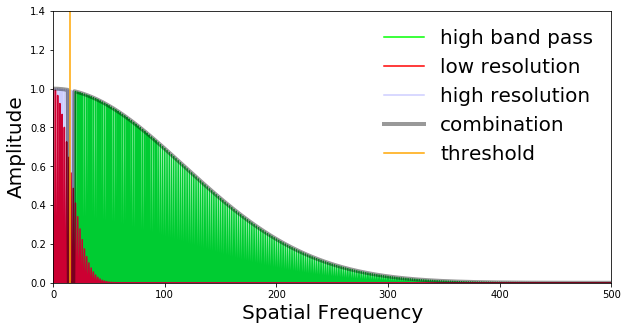

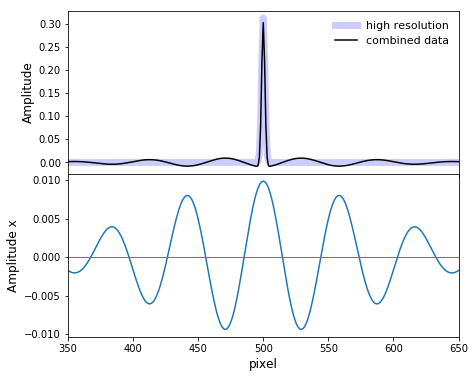

In [51]:
#for the fake interferometer data, step_th = (rr>=20)
step = (rr>=15) ######bad

w_low = (np.fft.fftshift(1-step)*np.fft.fft(data_high)/np.fft.fft(data_low))
fftsum = np.fft.fft(data_low) * w_low + np.fft.fft(data_high_int) * (np.fft.fftshift(step))


plt.figure(figsize=(10, 5))

plt.plot(x,np.fft.fft(data_high_int),color = 'lime',label='high band pass')
plt.plot(x,np.fft.fft(data_low),color = 'red',label='low resolution')
plt.plot(x,np.fft.fft(data_high),color = (0, 0, 1.0, 0.2),label='high resolution')


plt.plot(x,np.abs(fftsum.real),linewidth = 4.,label='combination',linestyle='-',color = 'black',alpha=0.4)

plt.axvline(x= 15, color ='orange',label='threshold') 

plt.xlim(0,500)
plt.ylim(0,1.4)
legend = plt.legend(loc='upper right', shadow=True, fontsize=20.,frameon=False)
plt.xlabel('Spatial Frequency',fontsize=20.)
plt.ylabel('Amplitude',fontsize=20.)




########to image domain#######
combine = np.fft.ifft(fftsum)


fig, axs = plt.subplots(2, 1, sharex=True,figsize=(7, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(x,data_high,color = (0, 0, 1.0, 0.2), linewidth = 7.,label='high resolution')
#axs[0].plot(x,data_low,color = 'red',linewidth = 3.,label='low resolution')
#axs[0].plot(x,data_high_int,color = 'lime',linewidth = 3.,label='high resolution (int)')
axs[0].plot(x, combine,color = 'black',label='combined data')
axs[0].set_xlim(350, 650)
legend = axs[0].legend(loc='upper right', shadow=True, fontsize=11,frameon=False)
sub = data_high - combine

#axs[1].plot(x, sub * 1e15)
axs[1].plot(x, sub)

axs[1].set_xlabel('pixel',fontsize='large')
#axs[1].set_ylabel('Amplitude x 10$^{-15}$',fontsize='large')
axs[1].set_ylabel('Amplitude x',fontsize='large')
axs[0].set_ylabel('Amplitude',fontsize='large')
axs[1].axhline(y=0.,color=(0.5,0.5,0.0),linewidth = 1)

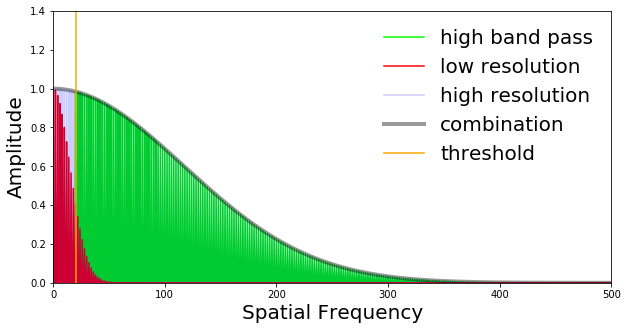

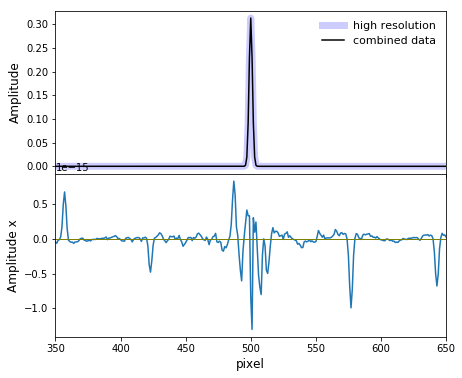

In [52]:
#J-comb, following Section 2.3

#for the fake interferometer data, step_th = (rr>=20)
step = (rr>=20) ######good

w_low = (np.fft.fftshift(1-step)*np.fft.fft(data_high)/np.fft.fft(data_low))
fftsum = np.fft.fft(data_low) * w_low + np.fft.fft(data_high_int) * (np.fft.fftshift(step))


plt.figure(figsize=(10, 5))

plt.plot(x,np.fft.fft(data_high_int),color = 'lime',label='high band pass')
plt.plot(x,np.fft.fft(data_low),color = 'red',label='low resolution')
plt.plot(x,np.fft.fft(data_high),color = (0, 0, 1.0, 0.2),label='high resolution')


plt.plot(x,np.abs(fftsum.real),linewidth = 4.,label='combination',linestyle='-',color = 'black',alpha=0.4)

plt.axvline(x= 20, color ='orange',label='threshold') 

plt.xlim(0,500)
plt.ylim(0,1.4)
legend = plt.legend(loc='upper right', shadow=True, fontsize=20.,frameon=False)
plt.xlabel('Spatial Frequency',fontsize=20.)
plt.ylabel('Amplitude',fontsize=20.)




########to image domain#######
combine = np.fft.ifft(fftsum)


fig, axs = plt.subplots(2, 1, sharex=True,figsize=(7, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(x,data_high,color = (0, 0, 1.0, 0.2), linewidth = 7.,label='high resolution')
#axs[0].plot(x,data_low,color = 'red',linewidth = 3.,label='low resolution')
#axs[0].plot(x,data_high_int,color = 'lime',linewidth = 3.,label='high resolution (int)')
axs[0].plot(x, combine,color = 'black',label='combined data')
axs[0].set_xlim(350, 650)
legend = axs[0].legend(loc='upper right', shadow=True, fontsize=11,frameon=False)
sub = data_high - combine

#axs[1].plot(x, sub * 1e15)
axs[1].plot(x, sub)

axs[1].set_xlabel('pixel',fontsize='large')
#axs[1].set_ylabel('Amplitude x 10$^{-15}$',fontsize='large')
axs[1].set_ylabel('Amplitude x',fontsize='large')
axs[0].set_ylabel('Amplitude',fontsize='large')
axs[1].axhline(y=0.,color=(0.5,0.5,0.0),linewidth = 1)

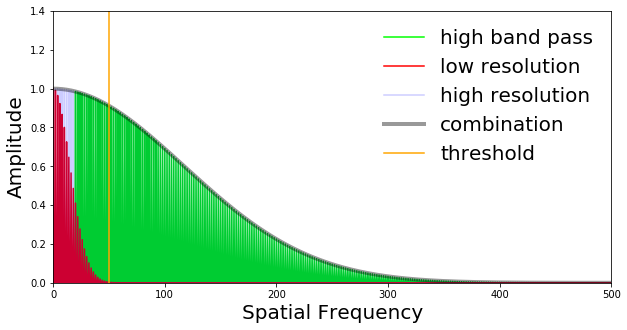

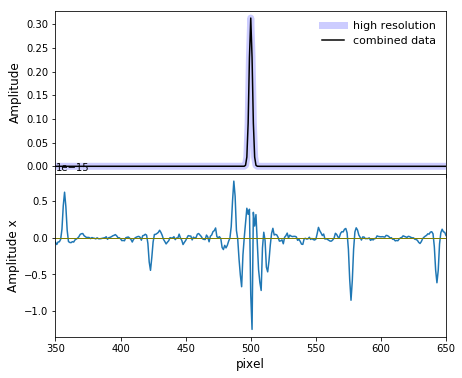

In [53]:
#J-comb, following Section 2.3

#for the fake interferometer data, step_th = (rr>=20)
step = (rr>=50) ######good

w_low = (np.fft.fftshift(1-step)*np.fft.fft(data_high)/np.fft.fft(data_low))
fftsum = np.fft.fft(data_low) * w_low + np.fft.fft(data_high_int) * (np.fft.fftshift(step))


plt.figure(figsize=(10, 5))

plt.plot(x,np.fft.fft(data_high_int),color = 'lime',label='high band pass')
plt.plot(x,np.fft.fft(data_low),color = 'red',label='low resolution')
plt.plot(x,np.fft.fft(data_high),color = (0, 0, 1.0, 0.2),label='high resolution')


plt.plot(x,np.abs(fftsum.real),linewidth = 4.,label='combination',linestyle='-',color = 'black',alpha=0.4)

plt.axvline(x= 50, color ='orange',label='threshold') 

plt.xlim(0,500)
plt.ylim(0,1.4)
legend = plt.legend(loc='upper right', shadow=True, fontsize=20.,frameon=False)
plt.xlabel('Spatial Frequency',fontsize=20.)
plt.ylabel('Amplitude',fontsize=20.)




########to image domain#######
combine = np.fft.ifft(fftsum)


fig, axs = plt.subplots(2, 1, sharex=True,figsize=(7, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(x,data_high,color = (0, 0, 1.0, 0.2), linewidth = 7.,label='high resolution')
#axs[0].plot(x,data_low,color = 'red',linewidth = 3.,label='low resolution')
#axs[0].plot(x,data_high_int,color = 'lime',linewidth = 3.,label='high resolution (int)')
axs[0].plot(x, combine,color = 'black',label='combined data')
axs[0].set_xlim(350, 650)
legend = axs[0].legend(loc='upper right', shadow=True, fontsize=11,frameon=False)
sub = data_high - combine

#axs[1].plot(x, sub * 1e15)
axs[1].plot(x, sub)

axs[1].set_xlabel('pixel',fontsize='large')
#axs[1].set_ylabel('Amplitude x 10$^{-15}$',fontsize='large')
axs[1].set_ylabel('Amplitude x',fontsize='large')
axs[0].set_ylabel('Amplitude',fontsize='large')
axs[1].axhline(y=0.,color=(0.5,0.5,0.0),linewidth = 1)

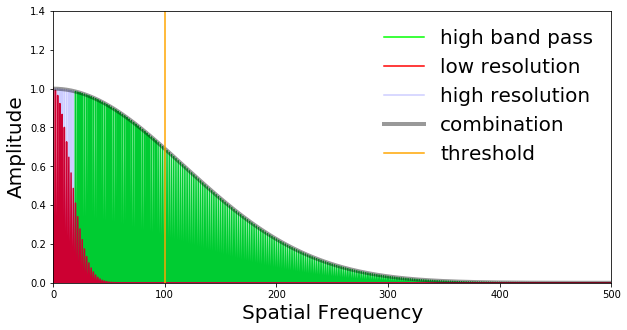

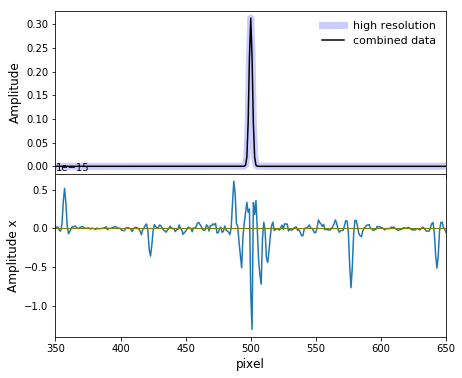

In [54]:
#J-comb, following Section 2.3

#for the fake interferometer data, step_th = (rr>=20)
step = (rr>=100) ######good

w_low = (np.fft.fftshift(1-step)*np.fft.fft(data_high)/np.fft.fft(data_low))
fftsum = np.fft.fft(data_low) * w_low + np.fft.fft(data_high_int) * (np.fft.fftshift(step))


plt.figure(figsize=(10, 5))

plt.plot(x,np.fft.fft(data_high_int),color = 'lime',label='high band pass')
plt.plot(x,np.fft.fft(data_low),color = 'red',label='low resolution')
plt.plot(x,np.fft.fft(data_high),color = (0, 0, 1.0, 0.2),label='high resolution')


plt.plot(x,np.abs(fftsum.real),linewidth = 4.,label='combination',linestyle='-',color = 'black',alpha=0.4)

plt.axvline(x= 100, color ='orange',label='threshold') 

plt.xlim(0,500)
plt.ylim(0,1.4)
legend = plt.legend(loc='upper right', shadow=True, fontsize=20.,frameon=False)
plt.xlabel('Spatial Frequency',fontsize=20.)
plt.ylabel('Amplitude',fontsize=20.)




########to image domain#######
combine = np.fft.ifft(fftsum)


fig, axs = plt.subplots(2, 1, sharex=True,figsize=(7, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(x,data_high,color = (0, 0, 1.0, 0.2), linewidth = 7.,label='high resolution')
#axs[0].plot(x,data_low,color = 'red',linewidth = 3.,label='low resolution')
#axs[0].plot(x,data_high_int,color = 'lime',linewidth = 3.,label='high resolution (int)')
axs[0].plot(x, combine,color = 'black',label='combined data')
axs[0].set_xlim(350, 650)
legend = axs[0].legend(loc='upper right', shadow=True, fontsize=11,frameon=False)
sub = data_high - combine

#axs[1].plot(x, sub * 1e15)
axs[1].plot(x, sub)

axs[1].set_xlabel('pixel',fontsize='large')
#axs[1].set_ylabel('Amplitude x 10$^{-15}$',fontsize='large')
axs[1].set_ylabel('Amplitude x',fontsize='large')
axs[0].set_ylabel('Amplitude',fontsize='large')
axs[1].axhline(y=0.,color=(0.5,0.5,0.0),linewidth = 1)

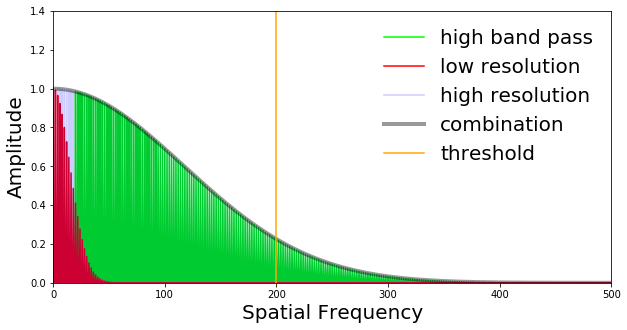

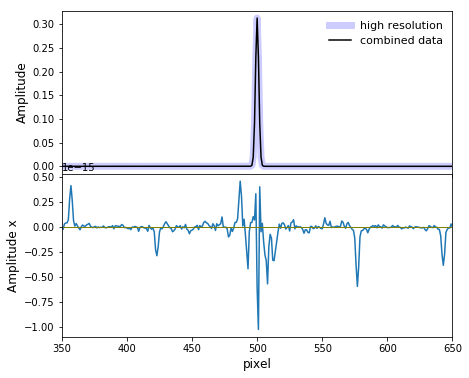

In [55]:
#J-comb, following Section 2.3

#for the fake interferometer data, step_th = (rr>=20)
step = (rr>=200) ######good

w_low = (np.fft.fftshift(1-step)*np.fft.fft(data_high)/np.fft.fft(data_low))
fftsum = np.fft.fft(data_low) * w_low + np.fft.fft(data_high_int) * (np.fft.fftshift(step))


plt.figure(figsize=(10, 5))

plt.plot(x,np.fft.fft(data_high_int),color = 'lime',label='high band pass')
plt.plot(x,np.fft.fft(data_low),color = 'red',label='low resolution')
plt.plot(x,np.fft.fft(data_high),color = (0, 0, 1.0, 0.2),label='high resolution')


plt.plot(x,np.abs(fftsum.real),linewidth = 4.,label='combination',linestyle='-',color = 'black',alpha=0.4)

plt.axvline(x= 200, color ='orange',label='threshold') 

plt.xlim(0,500)
plt.ylim(0,1.4)
legend = plt.legend(loc='upper right', shadow=True, fontsize=20.,frameon=False)
plt.xlabel('Spatial Frequency',fontsize=20.)
plt.ylabel('Amplitude',fontsize=20.)




########to image domain#######
combine = np.fft.ifft(fftsum)


fig, axs = plt.subplots(2, 1, sharex=True,figsize=(7, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(x,data_high,color = (0, 0, 1.0, 0.2), linewidth = 7.,label='high resolution')
#axs[0].plot(x,data_low,color = 'red',linewidth = 3.,label='low resolution')
#axs[0].plot(x,data_high_int,color = 'lime',linewidth = 3.,label='high resolution (int)')
axs[0].plot(x, combine,color = 'black',label='combined data')
axs[0].set_xlim(350, 650)
legend = axs[0].legend(loc='upper right', shadow=True, fontsize=11,frameon=False)
sub = data_high - combine

#axs[1].plot(x, sub * 1e15)
axs[1].plot(x, sub)

axs[1].set_xlabel('pixel',fontsize='large')
#axs[1].set_ylabel('Amplitude x 10$^{-15}$',fontsize='large')
axs[1].set_ylabel('Amplitude x',fontsize='large')
axs[0].set_ylabel('Amplitude',fontsize='large')
axs[1].axhline(y=0.,color=(0.5,0.5,0.0),linewidth = 1)